In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
grid = gera_grid(dx)

In [5]:
grid.shape

(2001, 2201)

In [6]:
np.piecewise(grid, [grid!=0, grid==0], [0, 1])

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [102]:
np.piecewise(grid, [grid!=2, grid==2], [0, 1])

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

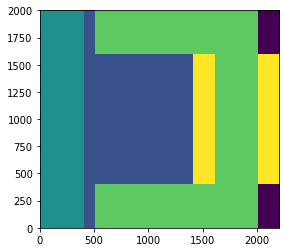

In [8]:
plt.imshow(grid, origin='lower', interpolation="none")

In [3]:
# Parâmetros
u0   = 4*np.pi*1e-7 #... H/m
urf  = 2500*u0 #........ H/m
urAr =    1*u0 #........ H/m
prof =    8e-2 #.......... m
dx   = 1e-2


def gera_grid(dx, l=22, h=20):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    -----------
    dx: float
        discretização da malha quadrada
    l: float (default=22)
        largura do sistema
    h: float (default=20)
        altura do sistema
        
    Returns
    -------
    grid: np.ndarray, dim=(N, M)
        grid do sistema, com os devidos elementos localizados através dos 
        códigos apresentados nas notas da função; note que M=int(l/dx) e
        N=int(h/dx)
    
    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1
    
    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)
    
    # definindo as regiões dos diferentes elementos
    armadura = (X <= 4)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 4, X < 5),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 5, X < 14),
            np.logical_and(Y > -6, Y < 6)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X >= 5, X <= 20),
            np.logical_or(Y <= -6, Y >= 6)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 16, X < 20)
        )
    
    bobina = np.logical_or(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(
            np.logical_and(X >= 14, X <= 16),
            np.logical_and(Y >= -6, Y <=  6)
            ),
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(
            np.logical_and(X >= 20, X <= 22),
            np.logical_and(Y >= -6, Y <=  6)
            )
        )
    
    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro] = 1
    grid[armadura]   = 2
    grid[nucleo]     = 3
    grid[bobina]     = 4
    
    return grid


def discretiza_elementos(dx, l=22, h=20):
    '''
    Função que gera um grid a partir das informações da malha e de suas dimensões
    e localiza os diferentes elementes, assignando a eles diferentes códigos
    '''


def Jz():
    '''
    Função que retorna a corrente elétrica distribuida na bobina na direção
    z (saindo da folha)
    
    Returns
    -------
    Jz: np.ndarray, dim=(N, M)
        corrente elétrica distribuida na direção do eixo z
    '''
    grid = gera_grid(dx)
    N = grid.shape[0]
    M = grid.shape[1]
    
    Jz = np.zeros((N, M))
    
    
    
            #Jz = 2e6*np.cos(np.pi*y/1.2e-1) + 8e5

    
    return Jz


In [12]:
a  = np.asarray([[1, 2], [2, 3]])
np.piecewise(a, [a!= 1, a==1], [0, 1])

array([[1, 0],
       [0, 0]])